In [16]:
import pandas as pd
import numpy as np
from Fingerprint.Hash2BitManager       import Hash2Bits, FindBitLength, GenerateFpsArray
from Kernels.Kernel          import funcTanimotoKernel_MMPKernel, funcTanimotoSklearn
from functools import partial
from Similarity.SimilarityHist import flattenTC
import seaborn as sns
import os
from scipy.special import rel_entr

def assign_vals(table, cols, new_col):
    for i, c in enumerate(cols):
        new_c = new_col[i]
        table[new_c] = 0
        for tid in table.index:
            data = pd.read_csv('./Dataset/Data/%s.tsv'%tid, sep='\t', index_col=0)
            table.loc[tid, new_c] = data[c].max()

    return table

def MakeSimilarityHistogram(target, use_zero=True, core_only=True, del_zero=True):
    df_tlist = pd.read_csv('./Dataset/target_list.tsv', sep='\t', index_col='chembl_tid') 
    df_main = pd.read_csv('./Dataset/Data/%s.tsv'%target, sep='\t', index_col=0)
    df_ecfp = pd.read_csv('./Dataset/ECFP/%s.tsv'%target, sep='\t', index_col=0)

    len_c = FindBitLength(df_ecfp, ['core'])
    len_s = FindBitLength(df_ecfp, ['sub1', 'sub2', 'overlap'])

    mms = df_ecfp.loc[df_main.drop_duplicates(['core_id']).index,:]

    fpgen = Hash2Bits()
    
    if not core_only:
        fp = GenerateFpsArray(mms['core'], nbits=len_c) 
        mat = funcTanimotoSklearn(fp, fp)
        sim = flattenTC(mat)
        #sim = np.max(mat, axis=1).reshape(-1)
        
    else:
        fp = fpgen.GetMMPfingerprints_DF_unfold(df_ecfp, ['core', 'sub1', 'sub2', 'overlap'], nbits=[len_c, len_s], overlap='concat')
        simfunc = partial(funcTanimotoKernel_MMPKernel, len_c=len_c)
        mat = simfunc(fp,fp)
        sim = flattenTC(mat)
        #sim = np.max(mat, axis=1).reshape(-1)
    
    sim = np.array(sim)
    
    if del_zero:
        sim  = sim[np.where(sim>0)[0]]
        bins = [0.00000001] + [0.1*i for i in range(1, 10)]
    
    else:
        bins = [0.1*i for i in range(10)]
        
    hist = np.histogram(sim, bins=bins, density=True)
    return hist

def kl_divergence(p, q):
	return sum(rel_entr(p,q))

def js_divergence(p, q):
    
    m = 0.5 * (p + q)
    
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)


def histogram_intersection(p, q):
    return sum([min(p_bin, q_bin) for p_bin, q_bin in zip(p, q)])

from itertools import product

def pairwise_calculation(func, labels, values):
    vals = np.array([func(i,j) for i, j in product(values, values)]).reshape(len(labels),-1)
    return pd.DataFrame(vals, index=labels, columns=labels)

In [17]:
svm = pd.read_csv('./Score_wodirection_trtssplit/SVM/mean.tsv', sep='\t', index_col=0)
xgb = pd.read_csv('./Score_wodirection_trtssplit/XGBoost/mean.tsv', sep='\t', index_col=0)
rf  = pd.read_csv('./Score_wodirection_trtssplit/Random_Forest/mean.tsv', sep='\t', index_col=0)
fcn = pd.read_csv('./Score_wodirection_trtssplit/FCNN/mean.tsv', sep='\t', index_col=0)
mpn = pd.read_csv('./Score_wodirection_trtssplit/MPNN/mean.tsv', sep='\t', index_col=0)
nn1 = pd.read_csv('./Score_wodirection_trtssplit/1NN/SVM/mean.tsv', sep='\t', index_col=0)
nn5 = pd.read_csv('./Score_wodirection_trtssplit/5NN/SVM/mean.tsv', sep='\t', index_col=0)


svm = assign_vals(svm, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
xgb = assign_vals(xgb, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
rf  = assign_vals(rf , cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
fcn = assign_vals(fcn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
mpn = assign_vals(mpn, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
nn1 = assign_vals(nn1, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])
nn5 = assign_vals(nn5, cols=['thres', 'core_id'], new_col=['thres', '#MMS'])


svm['model'] = 'svm'
xgb['model'] = 'xgb'
rf['model']  = 'rf'
fcn['model'] = 'fcnn'
mpn['model'] = 'mpnn'
nn1['model'] = '1NN'
nn5['model'] = '5NN'


all_score = pd.concat([svm, xgb, rf, fcn, mpn, nn1, nn5])

In [18]:
from collections import defaultdict

rank_target = defaultdict(list)
rank_score  = defaultdict(list)

for name, ml in zip(['svm', 'rf', 'fcn', 'mpn', '1nn', '5nn'], [svm, rf, fcn, mpn, nn1, nn5]):
    rank_target[name] = list(ml.sort_values('matthews_coeff', ascending=False).index[:10])
    rank_score[name]  = list(ml.sort_values('matthews_coeff', ascending=False).iloc[:10,:].loc[:, 'matthews_coeff'])
    
rank_target = pd.DataFrame.from_dict(rank_target, orient='columns')
rank_score = pd.DataFrame.from_dict(rank_score, orient='columns')

In [19]:
rank_target

,svm,rf,fcn,mpn,1nn,5nn
0,CHEMBL333,CHEMBL3018,CHEMBL4523,CHEMBL333,CHEMBL4523,CHEMBL2147
1,CHEMBL4523,CHEMBL5407,CHEMBL204,CHEMBL204,CHEMBL3991,CHEMBL3991
2,CHEMBL1800,CHEMBL4523,CHEMBL5023,CHEMBL2147,CHEMBL204,CHEMBL1800
3,CHEMBL5407,CHEMBL333,CHEMBL237,CHEMBL4072,CHEMBL5113,CHEMBL4523
4,CHEMBL2954,CHEMBL3991,CHEMBL2147,CHEMBL5407,CHEMBL3018,CHEMBL204
5,CHEMBL3991,CHEMBL1741186,CHEMBL2954,CHEMBL244,CHEMBL1800,CHEMBL1795117
6,CHEMBL2820,CHEMBL204,CHEMBL214,CHEMBL236,CHEMBL333,CHEMBL3018
7,CHEMBL1926488,CHEMBL1800,CHEMBL244,CHEMBL344,CHEMBL4072,CHEMBL255
8,CHEMBL204,CHEMBL2954,CHEMBL335,CHEMBL237,CHEMBL1795117,CHEMBL2954
9,CHEMBL3729,CHEMBL4072,CHEMBL255,CHEMBL251,CHEMBL2147,CHEMBL335


In [20]:
stats = pd.DataFrame(pd.Series(rank_target.values.reshape(-1)).value_counts())
stats['ml'] = ''

for target in stats.index:
    for ml in rank_target.columns:
        if any(target == rank_target[ml]):
            obj = stats.loc[target,'ml']
            stats.loc[target,'ml'] = obj + '  ' + ml

In [21]:
stats

,0,ml
CHEMBL204,6,svm rf fcn mpn 1nn 5nn
CHEMBL4523,5,svm rf fcn 1nn 5nn
CHEMBL2954,4,svm rf fcn 5nn
CHEMBL3991,4,svm rf 1nn 5nn
CHEMBL333,4,svm rf mpn 1nn
CHEMBL2147,4,fcn mpn 1nn 5nn
CHEMBL1800,4,svm rf 1nn 5nn
CHEMBL5407,3,svm rf mpn
CHEMBL3018,3,rf 1nn 5nn
CHEMBL4072,3,rf mpn 1nn


In [22]:
dict_hist      = {t:MakeSimilarityHistogram(target=t, core_only=False)[0] for t in stats.index}
dict_hist_core = {t:MakeSimilarityHistogram(target=t, core_only=True)[0] for t in stats.index}

/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: Sett

    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: Sett

    $ Overlap option is selected as concat
    $ Overlap option is selected as concat
    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: Sett

    $ Overlap option is selected as concat
    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat


/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])
/home/tamuras0/PYTHON_LIBRARY/myfuncs/Fingerprint/Hash2BitManager.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x:[int(h) for h in x.split(" ")] if isinstance(x, str) else [-1])


    $ Overlap option is selected as concat
    $ Overlap option is selected as concat


# Compare histogram

In [23]:
classic = [1800, 3991, 3018, 1741186, 1926488, 3729, 2820, 1795117, 5113]
nn_both = [244, 237]
nn_fcn  = [214, 5023]
nn_mpn  = [251, 236, 344]
allml   = [204, 5407, 2954, 333, 4523, 4072, 2147, 335, 255]

col = ['CHEMBL%d'%i for i in classic+nn_both+nn_fcn+nn_mpn+allml]

## js_divergence

In [24]:
js   = pairwise_calculation(js_divergence, col, [dict_hist[c] for c in col])
js_c = pairwise_calculation(js_divergence, col, [dict_hist_core[c] for c in col])
js

,CHEMBL1800,CHEMBL3991,CHEMBL3018,CHEMBL1741186,CHEMBL1926488,CHEMBL3729,CHEMBL2820,CHEMBL1795117,CHEMBL5113,CHEMBL244,...,CHEMBL344,CHEMBL204,CHEMBL5407,CHEMBL2954,CHEMBL333,CHEMBL4523,CHEMBL4072,CHEMBL2147,CHEMBL335,CHEMBL255
CHEMBL1800,0.000000,1.034453,1.258272,2.798411,0.378246,0.681892,0.216643,1.058343,0.548101,0.805993,...,0.380373,0.808504,0.164544,0.457943,0.471895,0.216783,0.353792,0.253407,0.198570,1.269722
CHEMBL3991,1.034453,0.000000,0.629651,2.976113,2.058480,0.190930,0.766599,2.338871,0.943608,1.430899,...,0.858285,1.313500,0.706969,0.861686,0.760865,1.290699,0.955889,1.376611,1.142239,2.486070
CHEMBL3018,1.258272,0.629651,0.000000,1.487627,2.127327,1.065225,1.004420,1.598203,1.998572,2.714948,...,1.795062,2.625691,1.175114,1.784916,1.655207,1.766513,1.709075,1.900644,1.288734,1.398225
CHEMBL1741186,2.798411,2.976113,1.487627,0.000000,2.850241,3.433308,2.475555,2.605474,3.818177,4.693333,...,3.744996,4.625257,3.019035,3.796292,3.801114,3.332220,3.475159,3.435393,3.158466,0.932659
CHEMBL1926488,0.378246,2.058480,2.127327,2.850241,0.000000,1.611494,0.603000,1.042812,0.995686,1.199665,...,0.933461,1.248432,0.721998,1.001728,1.099944,0.439605,0.764682,0.447648,0.618209,1.066262
CHEMBL3729,0.681892,0.190930,1.065225,3.433308,1.611494,0.000000,0.443005,2.336068,0.362473,0.650488,...,0.294473,0.568976,0.290671,0.289963,0.253815,0.686728,0.387624,0.731953,0.732586,2.578579
CHEMBL2820,0.216643,0.766599,1.004420,2.475555,0.603000,0.443005,0.000000,1.304238,0.396603,0.696355,...,0.286841,0.681553,0.093932,0.270286,0.344836,0.183743,0.173350,0.227115,0.220373,1.330328
CHEMBL1795117,1.058343,2.338871,1.598203,2.605474,1.042812,2.336068,1.304238,0.000000,2.307336,2.673797,...,2.081505,2.743432,1.496237,2.118279,2.134570,1.428006,1.889106,1.487145,0.907166,0.985364
CHEMBL5113,0.548101,0.943608,1.998572,3.818177,0.995686,0.362473,0.396603,2.307336,0.000000,0.107905,...,0.047804,0.089730,0.221338,0.080586,0.181308,0.257349,0.113742,0.238827,0.665506,2.527999
CHEMBL244,0.805993,1.430899,2.714948,4.693333,1.199665,0.650488,0.696355,2.673797,0.107905,0.000000,...,0.150452,0.007563,0.450636,0.148474,0.268641,0.350302,0.214861,0.312530,0.807204,3.177736


In [25]:
js.to_csv('./Score_wodirection_trtssplit/similarity_hist/js_div.tsv', sep='\t')
js_c.to_csv('./Score_wodirection_trtssplit/similarity_hist/js_div_core.tsv', sep='\t')

## histogram intersection

In [26]:
hi   = pairwise_calculation(histogram_intersection, col, [dict_hist[c] for c in col])
hi_c = pairwise_calculation(histogram_intersection, col, [dict_hist_core[c] for c in col])
hi

,CHEMBL1800,CHEMBL3991,CHEMBL3018,CHEMBL1741186,CHEMBL1926488,CHEMBL3729,CHEMBL2820,CHEMBL1795117,CHEMBL5113,CHEMBL244,...,CHEMBL344,CHEMBL204,CHEMBL5407,CHEMBL2954,CHEMBL333,CHEMBL4523,CHEMBL4072,CHEMBL2147,CHEMBL335,CHEMBL255
CHEMBL1800,10.000000,6.106884,5.642857,4.208333,8.398810,7.495332,8.766046,6.279762,7.765142,6.780277,...,7.943606,6.937514,8.698579,7.795910,7.895605,8.339286,8.082883,8.112714,8.916667,5.305307
CHEMBL3991,6.106884,10.000000,8.097826,3.276398,4.815218,8.228577,6.666667,4.311594,5.842233,4.843943,...,6.065976,5.034535,6.577481,5.981792,6.303950,5.346847,5.824619,5.156183,6.023120,4.117419
CHEMBL3018,5.642857,8.097826,10.000000,5.178571,4.666667,6.476833,6.257246,5.000000,4.250000,3.117964,...,4.523224,3.276630,5.766165,4.538485,4.876374,4.817568,4.691722,4.588040,5.662699,5.676071
CHEMBL1741186,4.208333,3.276398,5.178571,10.000000,4.142857,2.814464,4.472050,5.428571,2.832080,2.130357,...,2.829946,2.158599,3.602484,2.781299,2.857143,3.698842,3.254852,3.530167,3.968254,7.056576
CHEMBL1926488,8.398810,4.815218,4.666667,4.142857,10.000001,6.187068,7.753624,6.250000,6.795322,6.079980,...,6.851049,6.107745,7.674471,6.766061,6.871795,7.779280,7.248701,7.669662,7.769842,5.817398
CHEMBL3729,7.495332,8.228577,6.476833,2.814464,6.187068,10.000000,8.157316,4.013831,7.487128,6.578853,...,7.712524,6.772183,8.197255,7.696538,8.002098,6.955086,7.539364,6.781745,7.498716,3.522549
CHEMBL2820,8.766046,6.666667,6.257246,4.472050,7.753624,8.157316,10.000000,5.579710,7.851513,6.774066,...,8.208007,6.931303,8.993869,8.200949,8.091655,8.351744,8.360044,8.152267,9.095929,5.223252
CHEMBL1795117,6.279762,4.311594,5.000000,5.428571,6.250000,4.013831,5.579710,10.000000,4.152047,3.782387,...,4.306364,3.717478,5.105909,4.227879,4.322345,5.400901,4.591685,5.323064,6.261905,6.819227
CHEMBL5113,7.765142,5.842233,4.250000,2.832080,6.795322,7.487128,7.851513,4.152047,10.000001,8.867964,...,9.493817,9.025422,8.375678,9.335248,8.808560,8.693141,9.326574,8.816147,7.360067,3.424371
CHEMBL244,6.780277,4.843943,3.117964,2.130357,6.079980,6.578853,6.774066,3.782387,8.867964,10.000001,...,8.533544,9.772258,7.325905,8.557939,8.084201,8.289930,8.411521,8.405032,6.752526,2.716580


In [27]:
hi.to_csv('./Score_wodirection_trtssplit/similarity_hist/hi_sim.tsv', sep='\t')
hi_c.to_csv('./Score_wodirection_trtssplit/similarity_hist/hi_sim_core.tsv', sep='\t')

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

def heatmap(df, outpath=None, cmap_rev=True):
    # Create a mask
    mask = None

    #Create a matplotlib colormap from the sns seagreen color palette
    cmap = sns.light_palette("blue", reverse=cmap_rev, as_cmap=True )
    # Normalize to the range of possible values from df["c"]
    norm = matplotlib.colors.Normalize(vmin=df.min().min(), vmax=df.max().max())
    # create a color dictionary (value in c : color from colormap) 
    colors = {}
    for cval in df.values.reshape(-1):
        colors.update({cval : cmap(norm(cval))})
        
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(df, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, cmap=cmap)

    if outpath==None:
        plt.show()
    else:
        plt.savefig(outpath)
        
    return ax

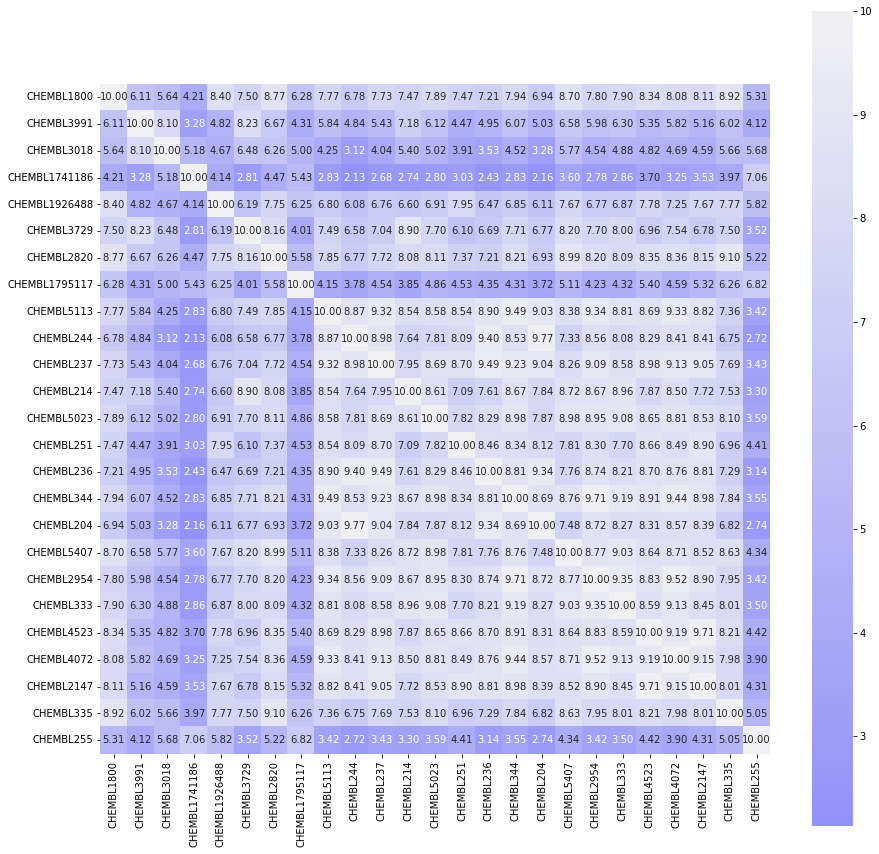

In [29]:
ax = heatmap(hi, outpath='./Score_wodirection_trtssplit/similarity_hist/heatmap_hi.svg')

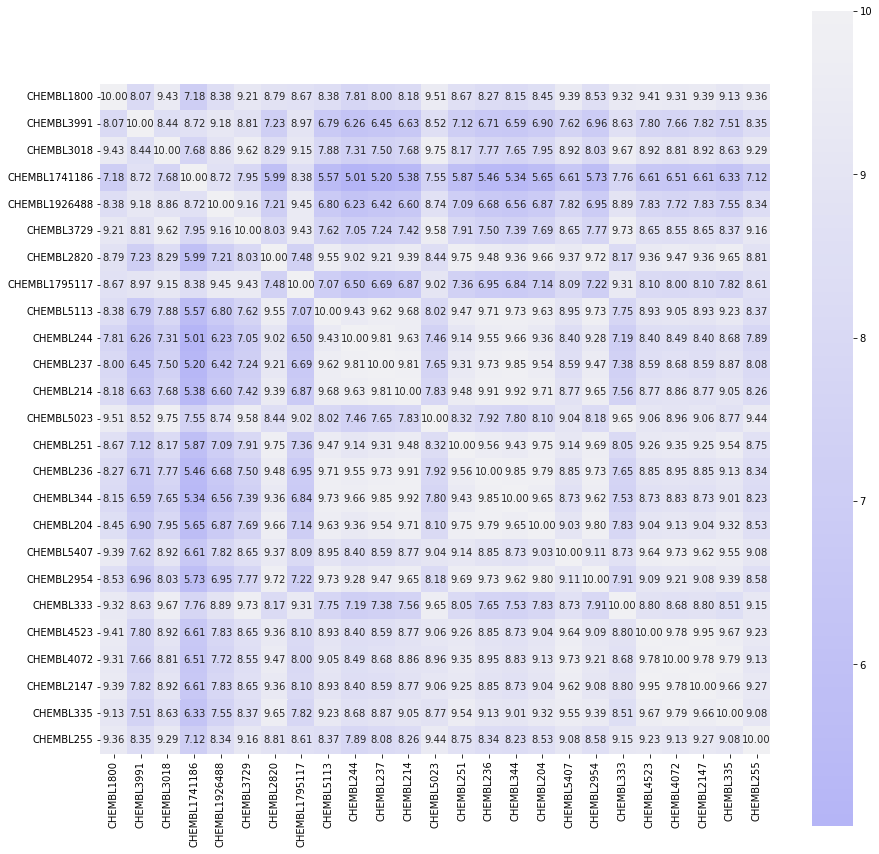

In [30]:
ax = heatmap(hi_c, outpath='./Score_wodirection_trtssplit/similarity_hist/heatmap_hi_core.svg')

In [31]:
def regional_average(val, r_from, r_to, c_from, c_to):
    
    val_sub = val[r_from:r_to, c_from:c_to]
    
    if r_from==c_from:
        ave = (val_sub.sum().sum() - np.diag(val_sub).sum()) / (val_sub.shape[0]*val_sub.shape[1]-np.diag(val_sub).shape[0])
    else:
        ave = val_sub.sum().sum() / (val_sub.shape[0]*val_sub.shape[1])
    return ave


def regional_median(val, r_from, r_to, c_from, c_to):
    
    val_sub = val[r_from:r_to, c_from:c_to]
    
    if r_from==c_from:
        triu = np.triu(val_sub,1).reshape(-1)
        med  = np.median(triu[np.where(triu>0)[0]])
    else:
        med  = np.median(val_sub.reshape(-1)) 
    return med
    

In [32]:
val = hi.values
idx = [0, 9, 16, 25]

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

5.88
6.1
6.35
6.1
8.44
7.91
6.35
7.91
7.54


In [33]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

5.97
6.6
6.77
6.6
8.53
8.5
6.77
8.5
8.42


In [34]:
val = hi_c.values
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

8.22
7.71
8.31
7.71
9.13
8.82
8.31
8.82
9.16


In [35]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

8.38
7.55
8.45
7.55
9.55
8.85
8.45
8.85
9.13


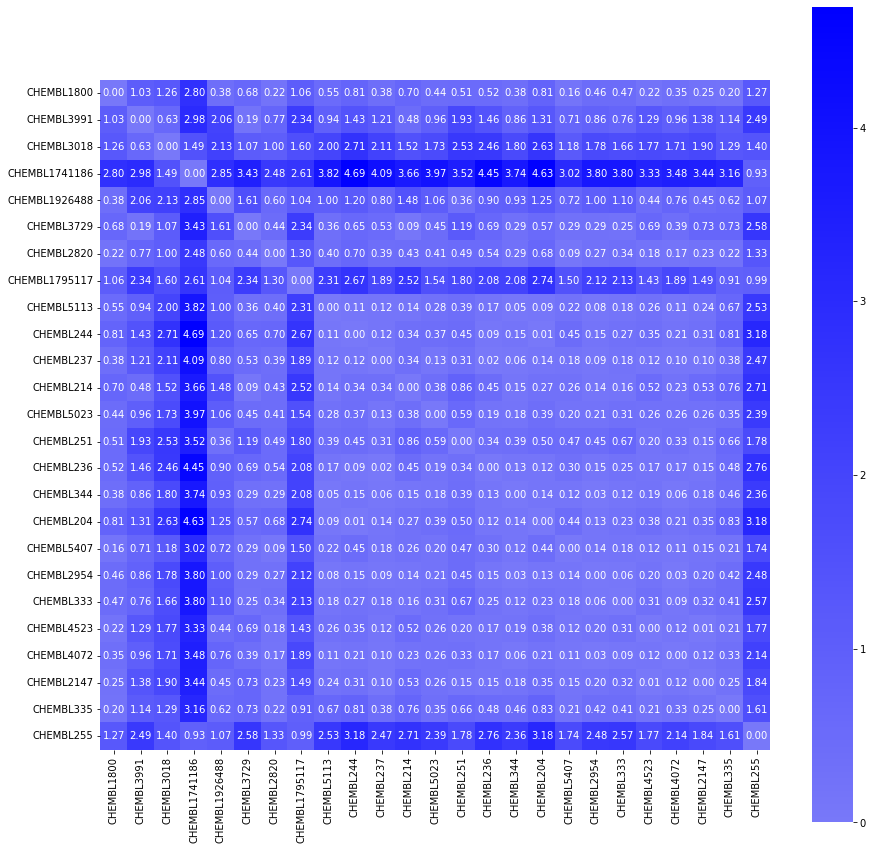

In [36]:
ax = heatmap(js, outpath='Score_wodirection_trtssplit/similarity_hist/heatmap_js.svg', cmap_rev=False)

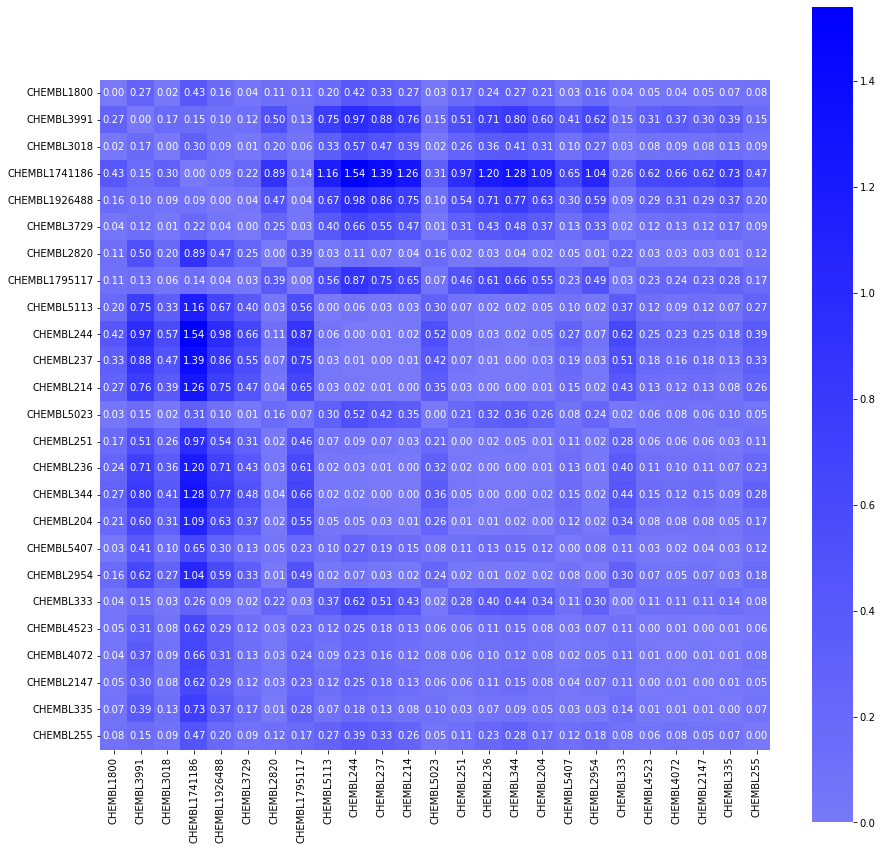

In [37]:
ax = heatmap(js_c, outpath='Score_wodirection_trtssplit/similarity_hist/heatmap_js_core.svg', cmap_rev=False)

In [38]:
val = js.values

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

1.49
1.35
1.2
1.35
0.29
0.53
1.2
0.53
0.66


In [39]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

1.16
0.9
0.91
0.9
0.31
0.26
0.91
0.26
0.24


In [40]:
val = js_c.values

for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        ave = regional_average(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(ave, 2))

0.27
0.47
0.25
0.47
0.12
0.15
0.25
0.15
0.08


In [41]:
for i in range(1, len(idx)):
    for j in range(1, len(idx)):
        med = regional_median(val, idx[i-1], idx[i], idx[j-1], idx[j])
        print(round(med, 2))

0.16
0.42
0.17
0.42
0.03
0.12
0.17
0.12
0.07


# Target name

In [42]:
tlist = pd.read_csv('./Dataset/target_list.tsv', sep='\t', index_col='chembl_tid')

for tid in hi.keys():
    print(tid, ': ', tlist.loc[tid, 'primary_name'])

CHEMBL1800 :  Corticotropin-releasing factor receptor 1
CHEMBL3991 :  Coagulation factor VII
CHEMBL3018 :  Suppressor of tumorigenicity 14 protein
CHEMBL1741186 :  Nuclear receptor ROR-gamma
CHEMBL1926488 :  Protoporphyrinogen oxidase
CHEMBL3729 :  Carbonic anhydrase 4
CHEMBL2820 :  Coagulation factor XI
CHEMBL1795117 :  Histone-lysine N-methyltransferase, H3 lysine-79 specific
CHEMBL5113 :  Orexin/Hypocretin receptor type 1
CHEMBL244 :  Coagulation factor X
CHEMBL237 :  Kappa-type opioid receptor
CHEMBL214 :  5-hydroxytryptamine receptor 1A
CHEMBL5023 :  E3 ubiquitin-protein ligase Mdm2
CHEMBL251 :  Adenosine receptor A2a
CHEMBL236 :  Delta-type opioid receptor
CHEMBL344 :  Melanin-concentrating hormone receptor 1
CHEMBL204 :  Prothrombin
CHEMBL5407 :  Serine/threonine-protein kinase pim-3
CHEMBL2954 :  Cathepsin S
CHEMBL333 :  72 kDa type IV collagenase
CHEMBL4523 :  Serine/threonine-protein kinase pim-2
CHEMBL4072 :  Cathepsin B
CHEMBL2147 :  Serine/threonine-protein kinase pim-1
CH